In [135]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree

from sklearn import decomposition
from sklearn.pipeline import Pipeline
# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

In [136]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-20-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-07-20,217.086474,3.903940e+08,217.086474,NaN,NaN,NaN,NaN,NaN
2017-07-21,231.143529,2.299701e+08,228.019739,14.057055,NaN,NaN,NaN,NaN
2017-07-22,226.718599,2.044678e+08,227.068159,-4.424930,NaN,NaN,NaN,NaN
2017-07-23,224.913407,1.442842e+08,225.518725,-1.805192,NaN,NaN,NaN,NaN
2017-07-24,206.810505,3.580211e+08,212.130219,-18.102902,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-15,1234.099139,1.681719e+10,1214.297642,42.968302,51.511001,-47.361288,26.063357,-73.424645
2022-07-16,1355.045640,1.902583e+10,1314.831927,120.946501,59.079833,-28.343586,36.064847,-64.408433
2022-07-17,1344.720284,1.579765e+10,1336.180753,-10.325356,58.243628,-13.944348,40.371268,-54.315616


In [137]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [138]:
my_data = mydf[myCols]
display(my_data)
my_data.corr()

,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
date,,,,,,,,
2017-08-22,316.788920,4.664746e+08,315.669228,66.968053,20.299982,-0.506760,20.806742,4.614450
2017-08-23,321.785298,3.977527e+08,320.037850,68.415202,20.485468,-0.257019,20.742487,4.996378
2017-08-24,329.025281,4.519507e+08,326.457443,70.435010,20.974888,0.185921,20.788967,7.239983
2017-08-25,329.865783,3.338393e+08,328.891971,70.669368,21.186355,0.317910,20.868445,0.840502
2017-08-26,343.341337,3.700521e+08,339.212947,74.203317,22.185567,1.053698,21.131869,13.475555
...,...,...,...,...,...,...,...,...
2022-07-15,1234.099139,1.681719e+10,1214.297642,51.511001,-47.361288,26.063357,-73.424645,42.968302
2022-07-16,1355.045640,1.902583e+10,1314.831927,59.079833,-28.343586,36.064847,-64.408433,120.946501
2022-07-17,1344.720284,1.579765e+10,1336.180753,58.243628,-13.944348,40.371268,-54.315616,-10.325356


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
ethereum,1.000000,0.532593,0.999823,0.091220,0.184963,-0.001620,0.196396,0.031173
ethereum_volume,0.532593,1.000000,0.533605,0.234424,0.278378,-0.111755,0.329667,-0.039582
ethereum_ewm,0.999823,0.533605,1.000000,0.085431,0.182732,-0.007398,0.195835,0.013137
ethereum_rsi,0.091220,0.234424,0.085431,1.000000,0.603669,0.396082,0.515854,0.234959
macd,0.184963,0.278378,0.182732,0.603669,1.000000,0.331414,0.955762,0.073132
macd_h,-0.001620,-0.111755,-0.007398,0.396082,0.331414,1.000000,0.039236,0.194077
macd_s,0.196396,0.329667,0.195835,0.515854,0.955762,0.039236,1.000000,0.016948
ethereum_diff,0.031173,-0.039582,0.013137,0.234959,0.073132,0.194077,0.016948,1.000000


## Linear Regression, scaled, shift data to predict off of yesterdays info

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.89943038, -0.61369587,  1.10923284, ..., -0.01421085,
         0.20135522,  0.04981991],
       [-0.90440643, -0.61012567,  1.21169983, ..., -0.00461809,
         0.20058703,  0.05468361],
       [-0.90048204, -0.60487934,  1.35471457, ...,  0.0123956 ,
         0.20114272,  0.083255  ],
       ...,
       [ 0.44442157,  0.20285706,  0.55069884, ...,  1.39053618,
        -0.81742823,  1.53126149],
       [ 0.21067423,  0.22030412,  0.49149037, ...,  1.55594952,
        -0.69676434, -0.14043247],
       [ 0.98107287,  0.35717863,  1.23073456, ...,  2.15119946,
        -0.5297824 ,  2.86829432]])

X_train: 
(1732, 7)
X_test: 
(60, 7)
y_train: 
(1732,)
y_test: 
(60,)
linear regression with no scaling
Root Mean squared error: 83.63
               ethereum  pred_linear_reg
date                                    
2022-05-21  1978.147133      1966.548215
2022-05-22  2046.646350      1981.049552
2022-05-23  1974.581194      2043.787943
2022-05-24  1979.770545      1981.351333
2022-05-25  1944.842845      1988.976273
2022-05-26  1807.969474      1954.171112
2022-05-27  1724.875734      1830.660550
2022-05-28  1798.694855      1750.331784
2022-05-29  1814.983160      1804.880061
2022-05-30  1995.936484      1813.447635
2022-05-31  1944.078767      1986.832901
2022-06-01  1828.892655      1943.904677
2022-06-02  1833.089841      1849.079973
2022-06-03  1776.979907      1849.801639
2022-06-04  1804.261670      1790.780138
2022-06-05  1805.331395      1811.041746
2022-06-06  1860.181307      1808.511930
2022-06-07  1818.387712      1862.451428
2022-06-08  1794.539626      1827.067943
2022

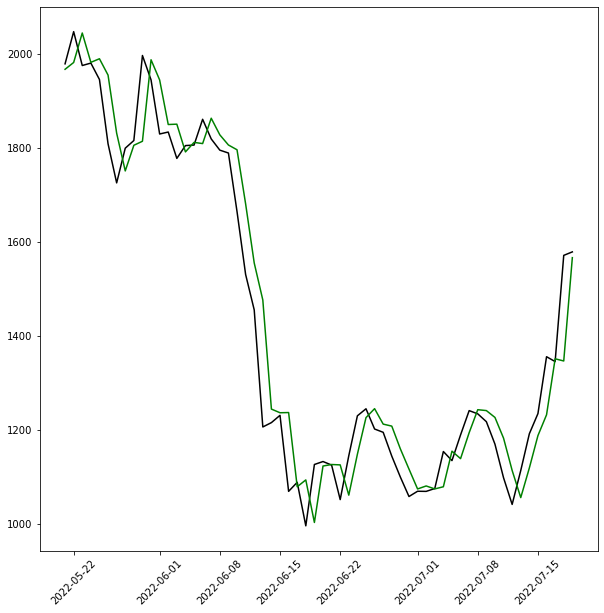

In [139]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

y_check1 = pd.DataFrame(y_test)
# print(y_check1)
y_check1['pred_linear_reg']= y_pred
print(y_check1)
plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.show()

# XGBOOST SCALED Shifted 1 day

In [154]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
preds=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
print('xgb rmse: ', rmse)
# y_check1['pred_xgb']= preds
# plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
# plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
# plt.plot(y_check1.index,y_check1['pred_xgb'], color = 'blue')
# plt.xticks(rotation=45)
# plt.show()

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.89943038, -0.61369587,  1.10923284, ..., -0.01421085,
         0.20135522,  0.04981991],
       [-0.90440643, -0.61012567,  1.21169983, ..., -0.00461809,
         0.20058703,  0.05468361],
       [-0.90048204, -0.60487934,  1.35471457, ...,  0.0123956 ,
         0.20114272,  0.083255  ],
       ...,
       [ 0.44442157,  0.20285706,  0.55069884, ...,  1.39053618,
        -0.81742823,  1.53126149],
       [ 0.21067423,  0.22030412,  0.49149037, ...,  1.55594952,
        -0.69676434, -0.14043247],
       [ 0.98107287,  0.35717863,  1.23073456, ...,  2.15119946,
        -0.5297824 ,  2.86829432]])

X_train: 
(1732, 7)
X_test: 
(60, 7)
y_train: 
(1732,)
y_test: 
(60,)
xgb rmse:  372.8062064287131


In [155]:
parameters = {
    'max_depth': range (2, 10, 1),
    'booster': ['gbtree', 'gblinear'],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [10,50,60,200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05]
#     'eval_metric': ['rmse', 'mae', 'mape']
}
grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_...ta_step=0,
                                    max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
  

In [156]:
grid_search.best_estimator_
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_train = grid_search.best_estimator_.predict(X_train)

y_pred = grid_search.best_estimator_.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))

print('xgb rmse: ', rmse)

xgb rmse:  185.62539060934196


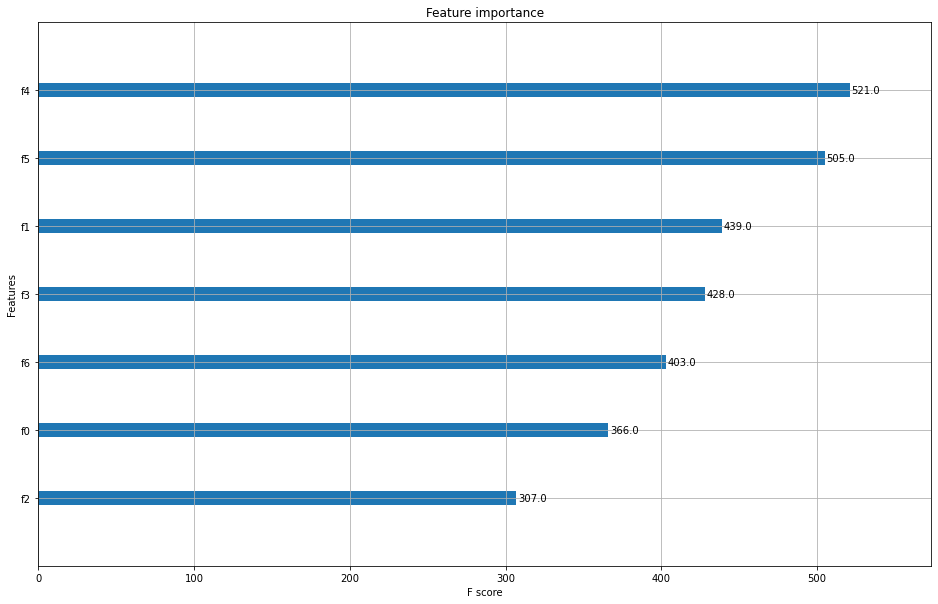

In [157]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

# sliding window

### train test split and create sliding window

In [143]:
seq=list(mydf['ethereum'])
# display(seq)

window_size = 10
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)
display(sliding_df)
y = sliding_df[0]
X = sliding_df.drop(columns=[0]) 
X=scaler.fit_transform(X)
# print('X')
# display(X)
# print('y')
# display(y)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


,0,1,2,3,4,5,6,7,8,9
0,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057
1,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057,346.398775
2,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057,346.398775,349.929240
3,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057,346.398775,349.929240,299.717332
4,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057,346.398775,349.929240,299.717332,318.972804
...,...,...,...,...,...,...,...,...,...,...
1779,1188.725643,1240.378406,1233.514679,1216.849707,1169.012708,1097.449438,1040.797146,1112.920783,1191.130837,1234.099139
1780,1240.378406,1233.514679,1216.849707,1169.012708,1097.449438,1040.797146,1112.920783,1191.130837,1234.099139,1355.045640
1781,1233.514679,1216.849707,1169.012708,1097.449438,1040.797146,1112.920783,1191.130837,1234.099139,1355.045640,1344.720284
1782,1216.849707,1169.012708,1097.449438,1040.797146,1112.920783,1191.130837,1234.099139,1355.045640,1344.720284,1570.658959


X_train: 
(1724, 9)
X_test: 
(60, 9)
y_train: 
(1724,)
y_test: 
(60,)


### xgboost on sliding window

In [144]:

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
preds=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
print('xgb rmse: ', rmse)

xgb rmse:  592.3995457096552


In [145]:
parameters = {
    'max_depth': range (2, 10, 1),
    'booster': ['gbtree', 'gblinear'],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [10,50,60,200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05]
#     'eval_metric': ['rmse', 'mae', 'mape']
}
grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_...ta_step=0,
                                    max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
  

In [146]:
grid_search.best_estimator_
grid_search.best_estimator_.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))

print('xgb rmse: ', rmse)

xgb rmse:  146.8284959584816


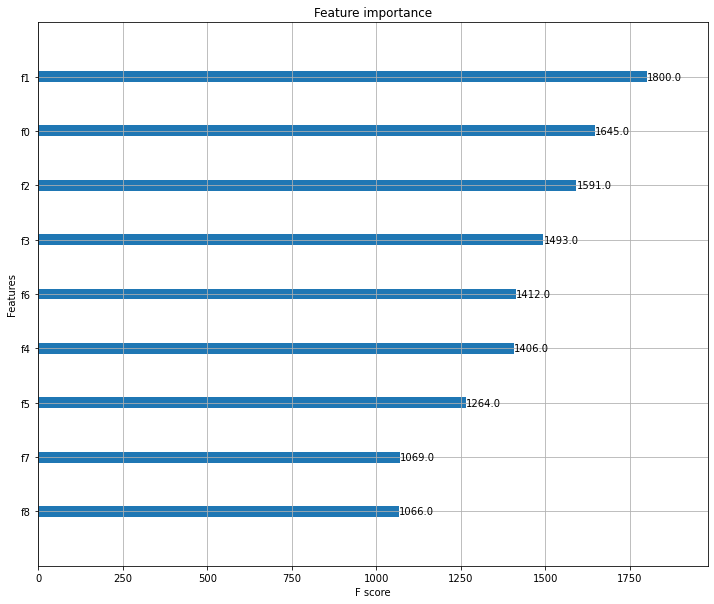

In [152]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

#linear regression on sliding window

Root Mean squared error: 81.21


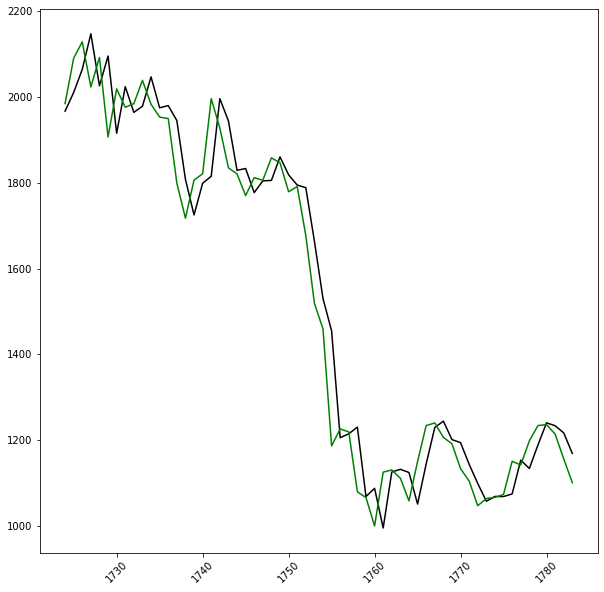

In [149]:
# print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

y_test_df = pd.DataFrame(y_test)
# print(y_check1)
y_test_df['pred_linear_reg']= y_pred
# print(y_check1)
plt.plot(y_test_df.index,y_test_df[0], color = 'black')
plt.plot(y_test_df.index,y_test_df['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.show()